In [1]:
import gym
import energym

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import random

from stable_baselines3 import DQN

In [2]:
# Random run to get some temp data:

env = gym.make('Eplus-discrete-hot-v1')

for i in range(1):
    obs = env.reset()
    rewards = []
    in_temp = []
    done = False
    current_month = 0

    while not done:
        a = env.action_space.sample()
        obs, reward, done, info = env.step(int(a))
        in_temp.append(info['temperature'])
        rewards.append(reward)

        if info['month'] != current_month: # display results every month
            current_month = info['month']
            print('Reward: ', sum(rewards), info)
    print('Episode ', i, 'Mean reward: ', np.mean(rewards), 'Cumulative reward: ', sum(rewards))
env.close()

[2021-09-02 09:30:29,241] EPLUS_ENV_discrete-hot-v1_MainThread_ROOT INFO:Creating EnergyPlus simulation environment...
[2021-09-02 09:30:29,277] EPLUS_ENV_discrete-hot-v1_MainThread_ROOT INFO:EnergyPlus working directory is in /workspaces/energym/Eplus-env-discrete-hot-v1-res3/Eplus-env-sub_run1


Reward:  -0.40314488461957476 {'timestep': 900.0, 'day': 1, 'month': 1, 'hour': 0, 'total_power': 1197.281193442195, 'total_power_no_units': -0.11972811934421951, 'comfort_penalty': -0.6865616498949301, 'temperature': 19.31343835010507, 'out_temperature': 4.4}
Reward:  -1165.6923003115671 {'timestep': 2678400.0, 'day': 1, 'month': 2, 'hour': 0, 'total_power': 219.57571786594, 'total_power_no_units': -0.021957571786594, 'comfort_penalty': -0.42181998364177176, 'temperature': 19.57818001635823, 'out_temperature': 12.1}
Reward:  -2030.4671252081307 {'timestep': 5097600.0, 'day': 1, 'month': 3, 'hour': 0, 'total_power': 219.57571786594, 'total_power_no_units': -0.021957571786594, 'comfort_penalty': -0.0, 'temperature': 20.63920251825407, 'out_temperature': 11.9}
Reward:  -2912.888389911754 {'timestep': 7776000.0, 'day': 1, 'month': 4, 'hour': 0, 'total_power': 1794.101961605891, 'total_power_no_units': -0.1794101961605891, 'comfort_penalty': -0.0, 'temperature': 21.97315479331908, 'out_tem

In [3]:
# Let's inject a drastic change in temp from 12-1pm on roughly the 15th of each month:

DA_time_steps = [(i*96 + j) for i in range(15, 346, 30) for j in range(48,52)]

In [4]:
DA_time_steps[:8]

[1488, 1489, 1490, 1491, 4368, 4369, 4370, 4371]

In [5]:
original_temps = [in_temp[DA_time_steps[i]] for i in range(len(DA_time_steps))]

original_temps[:8]

[23.37620368104505,
 21.2537587355655,
 22.80695235810453,
 21.24149764457421,
 25.36747329017386,
 25.66095385381567,
 24.07422492708559,
 25.03221057857932]

In [6]:
# Randomly make the injected noise either 10 deg higher or lower:

DA_temps = []


for i in range(0, len(DA_time_steps), 4):

    x = np.mean(original_temps[i:i+4])

    y = random.choices([-1, 1])[0]
    
    z = 4*[x + 10*y]

    DA_temps = DA_temps + z



DA_temps[:12]

[12.169603104822325,
 12.169603104822325,
 12.169603104822325,
 12.169603104822325,
 35.03371566241361,
 35.03371566241361,
 35.03371566241361,
 35.03371566241361,
 10.680603725310164,
 10.680603725310164,
 10.680603725310164,
 10.680603725310164]

In [7]:
# We can assume these changes to be AC malfunctions (breaks and gets too hot, or goes into overdrive and gets too cold)

# NOTE: in DA, assume the DA temps to be more accurate than the forecast temps

In [8]:
import time

In [9]:
###### Regular DQN ######

model = DQN.load("DQN models/regular_DQN_hot")

env = gym.make('Eplus-discrete-hot-v1')


start_time = time.time()

for i in range(1):
    obs = env.reset()

    rewards = []
    total_power = []
    in_temp = []
    out_temp = []
    actions = []
    comfort_penalties = []
    merged_temps = []
    done = False
    current_month = 0

    count = 0
    counter = 0

    while not done:
        # Predict next step:
        a, _ = model.predict(obs)
        # Observe next state and reward:
        obs, reward, done, info = env.step(int(a))

        if count in DA_time_steps:
            print()
            print('-------')
            print(env.current_obs[8])
            print()
            print(DA_temps[counter])
            print()

            env.update_temp(DA_temps[counter], background_var = 0.05, actual_var = 0.005)

            print(env.current_obs[8])
            print('-------')
            print()

            # store updated temps for plotting:
            merged_temps.append(env.current_obs[8])

            counter += 1


        # Store information for plotting:
        rewards.append(reward)
        total_power.append(info['total_power'])
        in_temp.append(env.current_obs[8])
        out_temp.append(info['out_temperature'])
        actions.append(int(a))
        comfort_penalties.append(info['comfort_penalty'])

        count += 1

        if info['month'] != current_month: # display results every month
            current_month = info['month']
            print('Reward: ', sum(rewards), info)
    print('Episode ', i, 'Mean reward: ', np.mean(rewards), 'Cumulative reward: ', sum(rewards))
env.close()


print()
print("--- %s seconds taken to run ---" % (time.time() - start_time))

[2021-09-02 09:32:00,535] EPLUS_ENV_discrete-hot-v1_MainThread_ROOT INFO:Creating EnergyPlus simulation environment...
[2021-09-02 09:32:00,535] EPLUS_ENV_discrete-hot-v1_MainThread_ROOT INFO:Creating EnergyPlus simulation environment...
[2021-09-02 09:32:00,545] EPLUS_ENV_discrete-hot-v1_MainThread_ROOT INFO:EnergyPlus working directory is in /workspaces/energym/Eplus-env-discrete-hot-v1-res4/Eplus-env-sub_run1
[2021-09-02 09:32:00,545] EPLUS_ENV_discrete-hot-v1_MainThread_ROOT INFO:EnergyPlus working directory is in /workspaces/energym/Eplus-env-discrete-hot-v1-res4/Eplus-env-sub_run1


Reward:  -0.40314488461957476 {'timestep': 900.0, 'day': 1, 'month': 1, 'hour': 0, 'total_power': 1197.281193442195, 'total_power_no_units': -0.11972811934421951, 'comfort_penalty': -0.6865616498949301, 'temperature': 19.31343835010507, 'out_temperature': 4.4}

-------
23.38889922713576

12.169603104822325

13.189539115941729
-------


-------
22.15629365647109

12.169603104822325

13.077484064063123
-------


-------
23.51067680428799

12.169603104822325

13.20060980477375
-------


-------
22.16864187842343

12.169603104822325

13.078606629695154
-------

Reward:  -1006.9753175944218 {'timestep': 2678400.0, 'day': 1, 'month': 2, 'hour': 0, 'total_power': 219.57571786594, 'total_power_no_units': -0.021957571786594, 'comfort_penalty': -0.0, 'temperature': 20.33028017597741, 'out_temperature': 12.1}

-------
21.25947853807652

35.03371566241361

33.78151228747387
-------


-------
23.41349441357746

35.03371566241361

33.97733191251942
-------


-------
21.17117387274055

35.03371566241

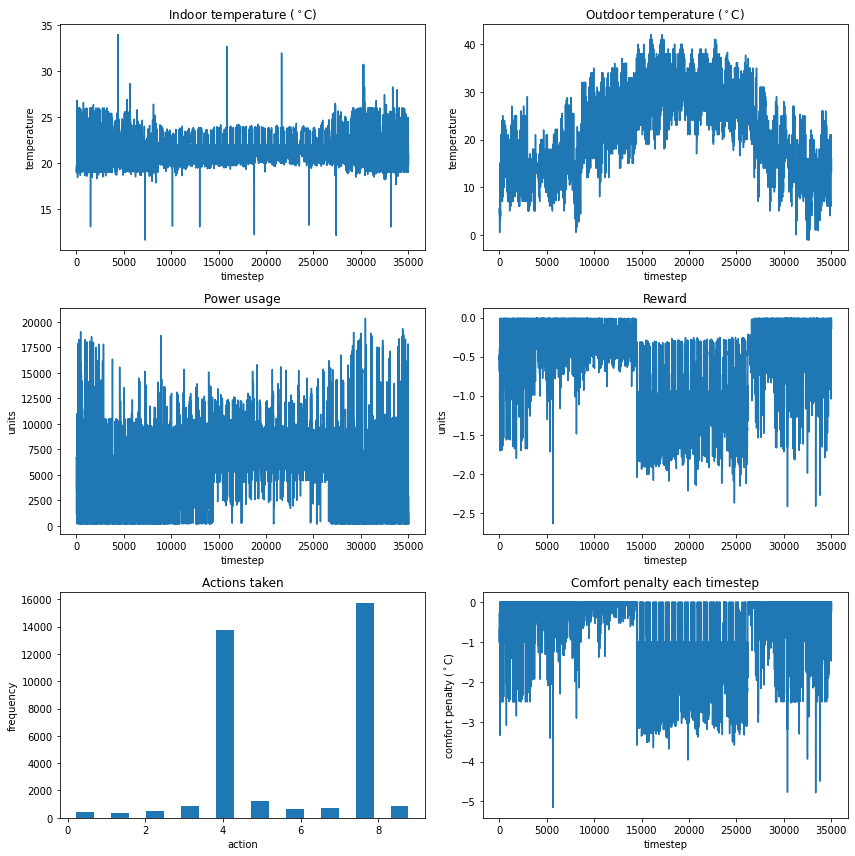

In [10]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (12,12))

axes[0,0].plot(in_temp)
axes[0,0].set_title('Indoor temperature ($^\circ$C)')
axes[0,0].set_xlabel('timestep')
axes[0,0].set_ylabel('temperature')

axes[0,1].plot(out_temp)
axes[0,1].set_title('Outdoor temperature ($^\circ$C)')
axes[0,1].set_xlabel('timestep')
axes[0,1].set_ylabel('temperature')

axes[1,0].plot(total_power)
axes[1,0].set_title('Power usage')
axes[1,0].set_xlabel('timestep')
axes[1,0].set_ylabel('units')

axes[1,1].plot(rewards)
axes[1,1].set_title('Reward')
axes[1,1].set_xlabel('timestep')
axes[1,1].set_ylabel('units')

axes[2,0].hist(actions, rwidth = 0.5)
axes[2,0].set_title('Actions taken')
axes[2,0].set_xlabel('action')
axes[2,0].set_ylabel('frequency')

axes[2,1].plot(comfort_penalties)
axes[2,1].set_title('Comfort penalty each timestep')
axes[2,1].set_xlabel('timestep')
axes[2,1].set_ylabel('comfort penalty ($^\circ$C)')


plt.tight_layout()

In [11]:
# Add the temperature comfort ranges:

# - for summer (01/06 to 30/09), range is [23, 26]
# - for winter (30/09 to 01/06, i.e. essentially absorbing spring and autumn), range is [20, 23.5]


# 01/06 corresponds to: day 151 = timestep 14496
# 30/09 corresponds to: day 273 = timestep 26208

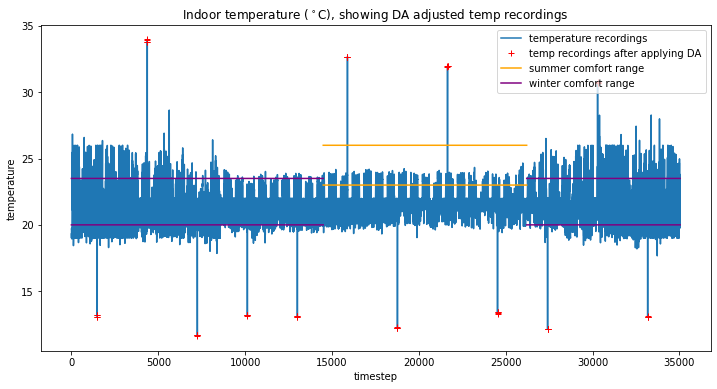

In [12]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12,6))

ax.plot(in_temp, label = 'temperature recordings')
ax.set_title('Indoor temperature ($^\circ$C), showing DA adjusted temp recordings')
ax.set_xlabel('timestep')
ax.set_ylabel('temperature')

ax.plot(DA_time_steps, merged_temps, 
        'r+', label = 'temp recordings after applying DA')


# summer comfort range:
ax.plot(list(range(14496,26208)), [23 for i in range(11712)], 'orange', label = 'summer comfort range')
ax.plot(list(range(14496,26208)), [26 for i in range(11712)], 'orange')


# winter comfort range:
ax.plot(list(range(26208, 35040)), [20 for i in range(8832)], 'purple', label = 'winter comfort range')
ax.plot(list(range(26208, 35040)), [23.5 for i in range(8832)], 'purple')

ax.plot(list(range(0,14496)), [20 for i in range(14496)], 'purple')
ax.plot(list(range(0,14496)), [23.5 for i in range(14496)], 'purple')


ax.legend()

plt.savefig('project_images/DQN_real_DA_hot_temps.png')

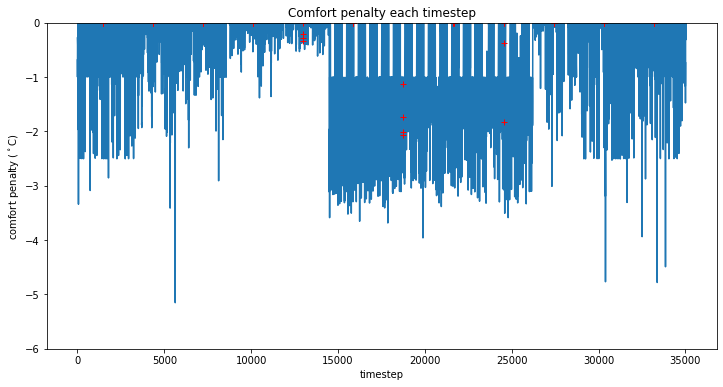

In [13]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12,6))

ax.plot(comfort_penalties)
ax.set_title('Comfort penalty each timestep')
ax.set_xlabel('timestep')
ax.set_ylabel('comfort penalty ($^\circ$C)')
ax.set_ylim([-6,0])

ax.plot(DA_time_steps, [comfort_penalties[DA_time_steps[i]] for i in range(len(DA_time_steps))], 'r+')


plt.savefig('project_images/DQN_real_DA_hot_penalties.png')

In [14]:
print("Total comfort penalty:", sum(comfort_penalties))
print()
print("Number of comfort penalties:", sum([0 if (x == 0) else 1 for x in comfort_penalties]))

Total comfort penalty: -18247.096158150853

Number of comfort penalties: 15248


In [15]:
print("Summer comfort penalty:", sum(comfort_penalties[14496:26208]))
print("Number of summer comfort penalties:", sum([0 if (x == 0) else 1 for x in comfort_penalties[14496:26208]]))

print()

print("Winter comfort penalty:", sum(comfort_penalties[0:14496]) + sum(comfort_penalties[26208:35040]))
print("Number of winter comfort penalties:", 
        sum([0 if (x == 0) else 1 for x in comfort_penalties[0:14496]]) + sum([0 if (x == 0) else 1 for x in comfort_penalties[26208:35040]]))

Summer comfort penalty: -14820.960569257193
Number of summer comfort penalties: 10064

Winter comfort penalty: -3426.1355888936187
Number of winter comfort penalties: 5184


In [16]:
###### DA DQN ######

model = DQN.load("DQN models/temp_DA_DQN_hot")

env = gym.make('Eplus-discrete-hot-v1')


start_time = time.time()

for i in range(1):
    obs = env.reset()

    rewards = []
    total_power = []
    in_temp = []
    out_temp = []
    actions = []
    comfort_penalties = []
    merged_temps = []
    done = False
    current_month = 0

    count = 0
    counter = 0

    while not done:
        # Predict next step:
        a, _ = model.predict(obs)
        # Observe next state and reward:
        obs, reward, done, info = env.step(int(a))

        if count in DA_time_steps:
            print()
            print('-------')
            print(env.current_obs[8])
            print()
            print(DA_temps[counter])
            print()

            env.update_temp(DA_temps[counter], background_var = 0.05, actual_var = 0.005)

            print(env.current_obs[8])
            print('-------')
            print()

            # store updated temps for plotting:
            merged_temps.append(env.current_obs[8])

            counter += 1


        # Store information for plotting:
        rewards.append(reward)
        total_power.append(info['total_power'])
        in_temp.append(env.current_obs[8])
        out_temp.append(info['out_temperature'])
        actions.append(int(a))
        comfort_penalties.append(info['comfort_penalty'])

        count += 1

        if info['month'] != current_month: # display results every month
            current_month = info['month']
            print('Reward: ', sum(rewards), info)
    print('Episode ', i, 'Mean reward: ', np.mean(rewards), 'Cumulative reward: ', sum(rewards))
env.close()


print()
print("--- %s seconds taken to run ---" % (time.time() - start_time))

[2021-09-02 09:35:35,499] EPLUS_ENV_discrete-hot-v1_MainThread_ROOT INFO:Creating EnergyPlus simulation environment...
[2021-09-02 09:35:35,499] EPLUS_ENV_discrete-hot-v1_MainThread_ROOT INFO:Creating EnergyPlus simulation environment...
[2021-09-02 09:35:35,499] EPLUS_ENV_discrete-hot-v1_MainThread_ROOT INFO:Creating EnergyPlus simulation environment...
[2021-09-02 09:35:35,511] EPLUS_ENV_discrete-hot-v1_MainThread_ROOT INFO:EnergyPlus working directory is in /workspaces/energym/Eplus-env-discrete-hot-v1-res5/Eplus-env-sub_run1
[2021-09-02 09:35:35,511] EPLUS_ENV_discrete-hot-v1_MainThread_ROOT INFO:EnergyPlus working directory is in /workspaces/energym/Eplus-env-discrete-hot-v1-res5/Eplus-env-sub_run1
[2021-09-02 09:35:35,511] EPLUS_ENV_discrete-hot-v1_MainThread_ROOT INFO:EnergyPlus working directory is in /workspaces/energym/Eplus-env-discrete-hot-v1-res5/Eplus-env-sub_run1


Reward:  -0.1978378613531864 {'timestep': 900.0, 'day': 1, 'month': 1, 'hour': 0, 'total_power': 3956.757227063728, 'total_power_no_units': -0.3956757227063728, 'comfort_penalty': -0.0, 'temperature': 20.89852933955802, 'out_temperature': 4.4}

-------
23.33228517552153

12.169603104822325

13.1843923839768
-------


-------
23.77700656845465

12.169603104822325

13.224821601516174
-------


-------
24.09194179085829

12.169603104822325

13.25345207628014
-------


-------
24.43152054585559

12.169603104822325

13.284322872188985
-------

Reward:  -889.5693347010591 {'timestep': 2678400.0, 'day': 1, 'month': 2, 'hour': 0, 'total_power': 1433.699783886628, 'total_power_no_units': -0.1433699783886628, 'comfort_penalty': -0.0, 'temperature': 21.00035948690292, 'out_temperature': 12.1}

-------
22.0111903847924

35.03371566241361

33.84984972808441
-------


-------
22.00970443697552

35.03371566241361

33.84971464191924
-------


-------
22.94852246613342

35.03371566241361

33.9350617354

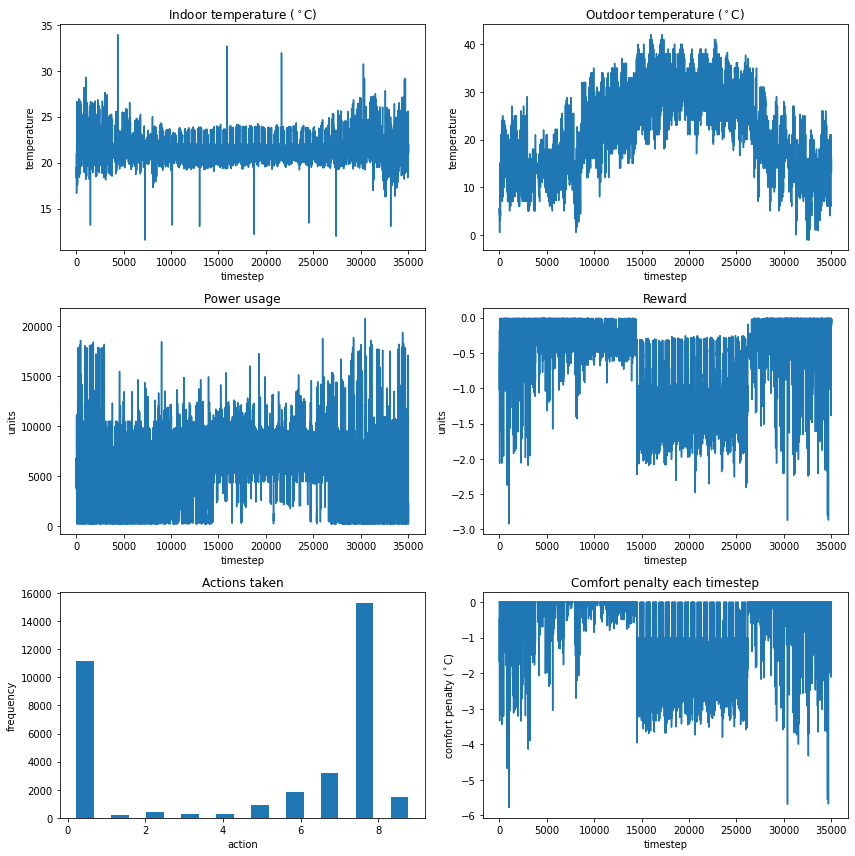

In [17]:
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (12,12))

axes[0,0].plot(in_temp)
axes[0,0].set_title('Indoor temperature ($^\circ$C)')
axes[0,0].set_xlabel('timestep')
axes[0,0].set_ylabel('temperature')

axes[0,1].plot(out_temp)
axes[0,1].set_title('Outdoor temperature ($^\circ$C)')
axes[0,1].set_xlabel('timestep')
axes[0,1].set_ylabel('temperature')

axes[1,0].plot(total_power)
axes[1,0].set_title('Power usage')
axes[1,0].set_xlabel('timestep')
axes[1,0].set_ylabel('units')

axes[1,1].plot(rewards)
axes[1,1].set_title('Reward')
axes[1,1].set_xlabel('timestep')
axes[1,1].set_ylabel('units')

axes[2,0].hist(actions, rwidth = 0.5)
axes[2,0].set_title('Actions taken')
axes[2,0].set_xlabel('action')
axes[2,0].set_ylabel('frequency')

axes[2,1].plot(comfort_penalties)
axes[2,1].set_title('Comfort penalty each timestep')
axes[2,1].set_xlabel('timestep')
axes[2,1].set_ylabel('comfort penalty ($^\circ$C)')


plt.tight_layout()

In [18]:
# Add the temperature comfort ranges:

# - for summer (01/06 to 30/09), range is [23, 26]
# - for winter (30/09 to 01/06, i.e. essentially absorbing spring and autumn), range is [20, 23.5]


# 01/06 corresponds to: day 151 = timestep 14496
# 30/09 corresponds to: day 273 = timestep 26208

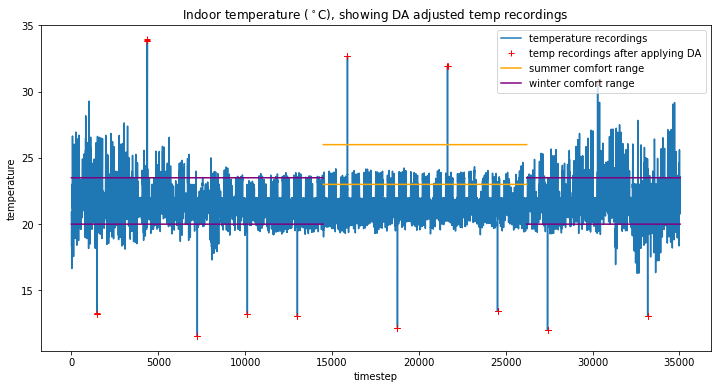

In [19]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12,6))

ax.plot(in_temp, label = 'temperature recordings')
ax.set_title('Indoor temperature ($^\circ$C), showing DA adjusted temp recordings')
ax.set_xlabel('timestep')
ax.set_ylabel('temperature')

ax.plot(DA_time_steps, merged_temps, 
        'r+', label = 'temp recordings after applying DA')


# summer comfort range:
ax.plot(list(range(14496,26208)), [23 for i in range(11712)], 'orange', label = 'summer comfort range')
ax.plot(list(range(14496,26208)), [26 for i in range(11712)], 'orange')


# winter comfort range:
ax.plot(list(range(26208, 35040)), [20 for i in range(8832)], 'purple', label = 'winter comfort range')
ax.plot(list(range(26208, 35040)), [23.5 for i in range(8832)], 'purple')

ax.plot(list(range(0,14496)), [20 for i in range(14496)], 'purple')
ax.plot(list(range(0,14496)), [23.5 for i in range(14496)], 'purple')


ax.legend()

plt.savefig('project_images/DA_DQN_real_DA_hot_temps.png')

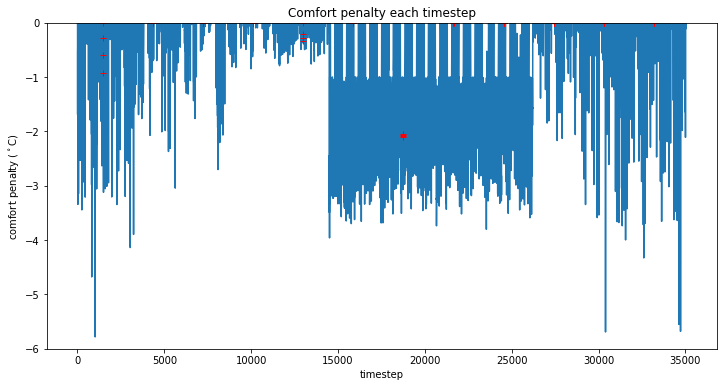

In [20]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12,6))

ax.plot(comfort_penalties)
ax.set_title('Comfort penalty each timestep')
ax.set_xlabel('timestep')
ax.set_ylabel('comfort penalty ($^\circ$C)')
ax.set_ylim([-6,0])

ax.plot(DA_time_steps, [comfort_penalties[DA_time_steps[i]] for i in range(len(DA_time_steps))], 'r+')


plt.savefig('project_images/DA_DQN_real_DA_hot_penalties.png')

In [21]:
print("Total comfort penalty:", sum(comfort_penalties))
print()
print("Number of comfort penalties:", sum([0 if (x == 0) else 1 for x in comfort_penalties]))

Total comfort penalty: -17893.249610916653

Number of comfort penalties: 12893


In [22]:
print("Summer comfort penalty:", sum(comfort_penalties[14496:26208]))
print("Number of summer comfort penalties:", sum([0 if (x == 0) else 1 for x in comfort_penalties[14496:26208]]))

print()

print("Winter comfort penalty:", sum(comfort_penalties[0:14496]) + sum(comfort_penalties[26208:35040]))
print("Number of winter comfort penalties:", 
        sum([0 if (x == 0) else 1 for x in comfort_penalties[0:14496]]) + sum([0 if (x == 0) else 1 for x in comfort_penalties[26208:35040]]))

Summer comfort penalty: -15304.984143479096
Number of summer comfort penalties: 10049

Winter comfort penalty: -2588.2654674374617
Number of winter comfort penalties: 2844


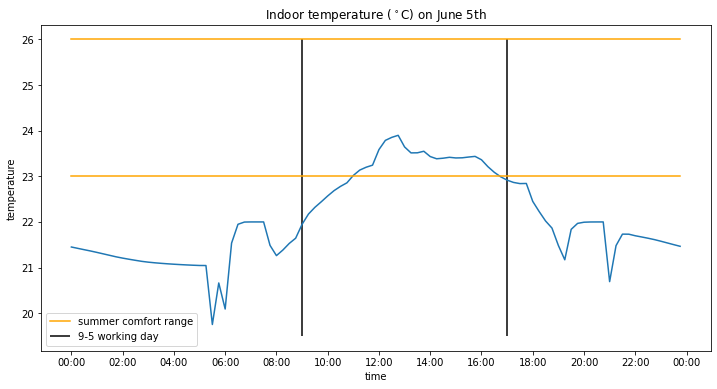

In [23]:
# Let's see how the temp varies over a 24 hour period. Note that summer is days 151 to 273 of the year.



fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12,6))

positions = [i*4 for i in range(0,25,2)]
labels = ("00:00", "02:00", "04:00", "06:00", "08:00", "10:00", "12:00", "14:00", "16:00", "18:00", "20:00", "22:00", "00:00")
plt.xticks(positions, labels)

ax.plot(in_temp[185*96:186*96])

ax.plot(list(range(0,96)), [23 for i in range(96)], 'orange', label = 'summer comfort range')
ax.plot(list(range(0,96)), [26 for i in range(96)], 'orange')

plt.vlines(9*4, ymin=19.5, ymax=26, colors='black', label = '9-5 working day')
plt.vlines(17*4, ymin=19.5, ymax=26, colors='black')

ax.set_xlabel("time")
ax.set_ylabel("temperature")

ax.set_title("Indoor temperature ($^\circ$C) on June 5th")

ax.legend()


plt.savefig('project_images/DA_DQN_day_night_temps.png')